# Replication of Li & Coates (2017) Figures

This notebook replicates the key figures from:

> Li, Y., & Coates, M. (2017). Particle Filtering With Invertible Particle Flow.  
> IEEE Transactions on Signal Processing, 65(15), 4102-4116.

**Figures:**
- Figure 1: Example estimated trajectories
- Figure 2: Average OMAT errors at each time step
- Figure 3: Boxplots of average OMAT errors
- Figure 4: Average ESS at each time step
- Table I: Summary statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from numpy.random import default_rng

# Style settings to match paper aesthetics
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (8, 6),
    'figure.dpi': 100,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
})

In [2]:
# Import particle flow package
import sys
sys.path.insert(0, '..')  # Adjust path as needed

from advanced_particle_filter.models import make_acoustic_ssm, make_acoustic_Q_filter
from advanced_particle_filter.filters import (
    ExtendedKalmanFilter, UnscentedKalmanFilter,
    BootstrapParticleFilter,
    EDHFlow, EDHParticleFilter,
    LEDHFlow, LEDHParticleFilter,
)
from advanced_particle_filter.utils import compute_omat

## Configuration

In [3]:
# Path to saved results (update this to your results file)
RESULTS_NPZ_PATH = 'pfresults/acoustic_experiment_full_20260225_215605.npz'  # Update this!
# 
# Filter display settings
FILTER_COLORS = {
    'EKF': 'tab:gray',
    'UKF': 'tab:brown',
    'EDH Flow': 'tab:cyan',
    'EDH-PF-PF': 'tab:blue',
    'LEDH Flow': 'tab:orange',
    'LEDH-PF-PF': 'tab:red',
    'BPF': 'tab:green',
}

FILTER_LINESTYLES = {
    'EKF': '-',
    'UKF': '-',
    'EDH Flow': '--',
    'EDH-PF-PF': '-',
    'LEDH Flow': '--',
    'LEDH-PF-PF': '-',
    'BPF': ':',
}

FILTER_MARKERS = {
    'EKF': '^',
    'UKF': '^',
    'EDH Flow': 'o',
    'EDH-PF-PF': 'x',
    'LEDH Flow': 'o',
    'LEDH-PF-PF': 'x',
    'BPF': 'x',
}

---
## Figure 1: Example Estimated Trajectories

Shows the tracking area with sensors, true trajectories, and estimated trajectories from LEDH-PF-PF.

In [4]:
def generate_figure1_data(seed=42):
    """
    Generate one trajectory and run LEDH-PF-PF to get estimates.
    
    Returns:
        states: [T+1, 16] true states
        estimates: [T+1, 16] estimated states
    """
    # Setup
    num_targets = 4
    T = 40
    
    # Q matrices
    Q_real = 0.05 * np.kron(np.eye(4), np.array([
        [1/3, 0, 0.5, 0],
        [0, 1/3, 0, 0.5],
        [0.5, 0, 1, 0],
        [0, 0.5, 0, 1],
    ]))
    Q_filter = make_acoustic_Q_filter(num_targets=4)
    
    # Initial state
    x0_true = np.array([12, 6, 0.001, 0.001,
                        32, 32, -0.001, -0.005,
                        20, 13, -0.1, 0.01,
                        15, 35, 0.002, 0.002])
    sigma0 = np.tile([10.0, 10.0, 1.0, 1.0], 4)
    
    # Create simulation model
    sim_model = make_acoustic_ssm(num_targets=4, Q=Q_real)
    
    # Generate trajectory
    rng = default_rng(seed)
    states = np.zeros((T + 1, 16))
    states[0] = sim_model.sample_dynamics(x0_true[np.newaxis, :], rng)[0]
    for t in range(1, T + 1):
        states[t] = sim_model.sample_dynamics(states[t-1:t], rng)[0]
    
    # Generate observations
    observations = np.zeros((T, 25))
    for t in range(T):
        y_mean = sim_model.obs_mean(states[t+1:t+2])[0]
        observations[t] = y_mean + rng.multivariate_normal(np.zeros(25), sim_model.obs_cov)
    
    # Create filter model
    filter_model = make_acoustic_ssm(num_targets=4, Q=Q_filter)
    m0 = x0_true + sigma0 * rng.standard_normal(16) * 0.5  # Smaller perturbation for visualization
    filter_model.initial_mean = m0.copy()
    filter_model.initial_cov = np.diag(sigma0 ** 2)
    filter_model._dynamics_cov_chol = np.linalg.cholesky(Q_filter + 1e-6 * np.eye(16))
    
    # Run LEDH-PF-PF
    ledh_pf = LEDHParticleFilter(n_particles=500, redraw=False, seed=seed+100)
    result = ledh_pf.filter(filter_model, observations, rng=default_rng(seed+200))
    
    return states, result.means


def plot_figure1(states, estimates, save_path=None):
    """
    Plot Figure 1: Example estimated trajectories.
    
    Args:
        states: [T+1, 16] true states
        estimates: [T+1, 16] estimated states
        save_path: Optional path to save figure
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Sensor positions (5x5 grid)
    sensor_positions = []
    for i in range(5):
        for j in range(5):
            sensor_positions.append([8*i, 8*j])  # 0, 8, 16, 24, 32, 40 -> but 5 points: 0,10,20,30,40
    # Actually paper uses grid intersections in 40x40 area
    sensor_x = np.linspace(0, 40, 5)
    sensor_y = np.linspace(0, 40, 5)
    sensor_xx, sensor_yy = np.meshgrid(sensor_x, sensor_y)
    
    ax.scatter(sensor_xx.flatten(), sensor_yy.flatten(), 
               marker='s', c='black', s=50, zorder=5, label='Sensors')
    
    # Target colors
    target_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    # Plot trajectories for each target
    for i in range(4):
        # True trajectory
        ax.plot(states[:, 4*i], states[:, 4*i+1], 
                '-', color=target_colors[i], linewidth=2,
                label=f'Target {i+1} (true)')
        
        # Estimated trajectory
        ax.plot(estimates[:, 4*i], estimates[:, 4*i+1], 
                ':', color=target_colors[i], linewidth=2,
                label=f'Target {i+1} (est.)')
        
        # Starting position
        ax.plot(states[0, 4*i], states[0, 4*i+1], 
                'x', color=target_colors[i], markersize=12, 
                markeredgewidth=3, zorder=10)
    
    ax.set_xlim([-2, 42])
    ax.set_ylim([-2, 42])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Figure 1: Estimated Trajectories using PF-PF (LEDH)')
    ax.legend(loc='upper left', ncol=2, fontsize=8)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

Generating Figure 1 data (running LEDH-PF-PF)...


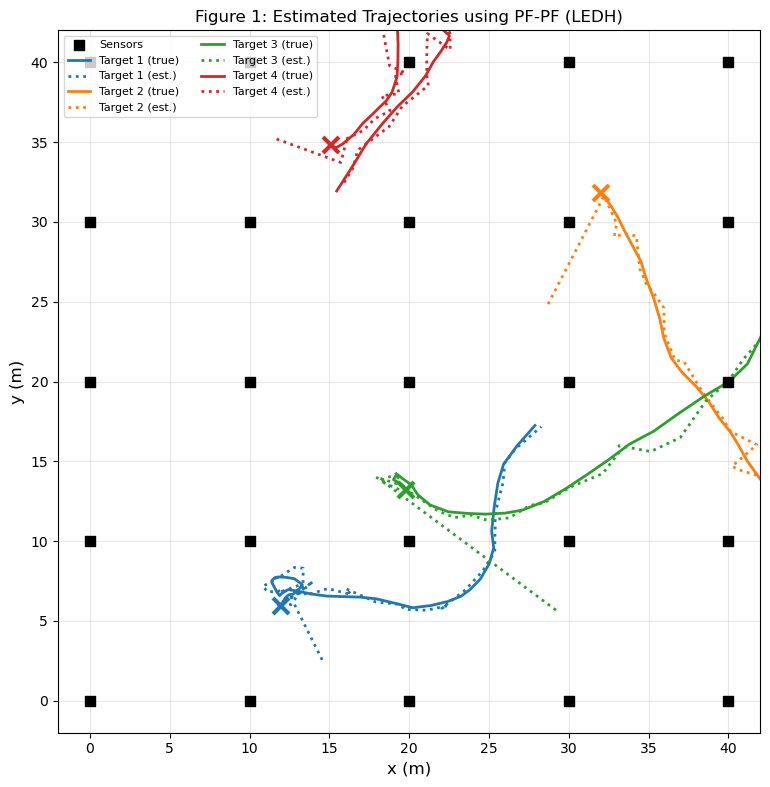

In [5]:
# Generate and plot Figure 1
print("Generating Figure 1 data (running LEDH-PF-PF)...")
states, estimates = generate_figure1_data(seed=1000)
plot_figure1(states, estimates, save_path='figure1_trajectories.png')

---
## Load Saved Experiment Results

Load the NPZ file containing results from `acoustic_experiment.py`.

In [6]:
def load_results(npz_path):
    """
    Load results from NPZ file.
    
    Returns:
        dict with filter names as keys and data arrays as values
    """
    data = np.load(npz_path, allow_pickle=True)
    
    # Get filter names
    filter_names = list(data['filter_names'])
    
    results = {}
    for name in filter_names:
        safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
        
        results[name] = {
            'omat_mean': data.get(f'{safe_name}_omat_mean', None),
            'ess_mean': data.get(f'{safe_name}_ess_mean', None),
            'runtime': data.get(f'{safe_name}_runtime', None),
            'omat_per_step': data.get(f'{safe_name}_omat_per_step', None),
            'ess_per_step': data.get(f'{safe_name}_ess_per_step', None),
        }
    
    return results, filter_names


# Try to load results
try:
    results, filter_names = load_results(RESULTS_NPZ_PATH)
    print(f"Loaded results for {len(filter_names)} filters:")
    for name in filter_names:
        n_trials = len(results[name]['omat_mean']) if results[name]['omat_mean'] is not None else 0
        print(f"  - {name}: {n_trials} trials")
except FileNotFoundError:
    print(f"Results file not found: {RESULTS_NPZ_PATH}")
    print("Please run acoustic_experiment.py first or update RESULTS_NPZ_PATH.")
    results = None

Loaded results for 7 filters:
  - EKF: 50 trials
  - UKF: 50 trials
  - EDH Flow: 50 trials
  - EDH-PF-PF: 50 trials
  - LEDH Flow: 50 trials
  - LEDH-PF-PF: 50 trials
  - BPF (N=100000): 50 trials


---
## Figure 2: Average OMAT Errors at Each Time Step

In [7]:
def plot_figure2(results, filter_names, save_path=None):
    """
    Plot Figure 2: Average OMAT errors at each time step.
    
    Args:
        results: dict with filter results
        filter_names: list of filter names to plot
        save_path: Optional path to save figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name in filter_names:
        omat_per_step = results[name].get('omat_per_step')
        if omat_per_step is None:
            continue
        
        # Average over trials
        mean_omat = np.nanmean(omat_per_step, axis=0)
        T = len(mean_omat)
        time_steps = np.arange(1, T + 1)
        
        # Get style
        color = FILTER_COLORS.get(name.split(' (')[0], 'black')  # Handle BPF (N=xxx)
        linestyle = FILTER_LINESTYLES.get(name.split(' (')[0], '-')
        marker = FILTER_MARKERS.get(name.split(' (')[0], 'o')
        
        # Plot every 5th point with marker for clarity
        ax.plot(time_steps, mean_omat, 
                linestyle=linestyle, color=color, 
                marker=marker, markevery=5,
                label=name)
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Average OMAT (m)')
    ax.set_title('Figure 2: Average OMAT Errors at Each Time Step')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, T])
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

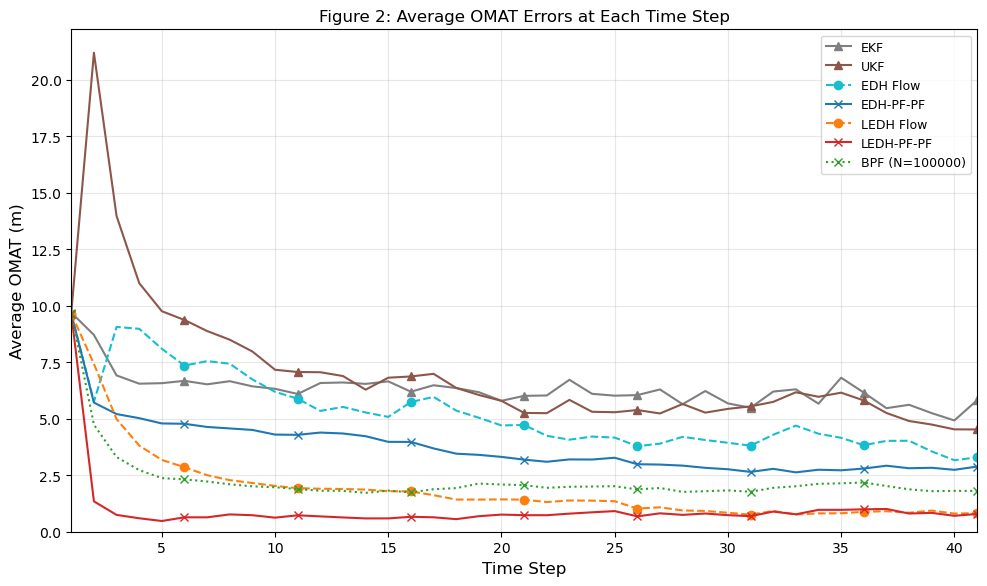

In [8]:
if results is not None:
    plot_figure2(results, filter_names, save_path='figure2_omat_vs_time.png')

---
## Figure 3: Boxplots of Average OMAT Errors

In [9]:
def plot_figure3(results, filter_names, save_path=None):
    """
    Plot Figure 3: Boxplots of average OMAT errors.
    
    Args:
        results: dict with filter results
        filter_names: list of filter names to plot
        save_path: Optional path to save figure
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Collect data for boxplot
    box_data = []
    box_labels = []
    box_colors = []
    
    for name in filter_names:
        omat_mean = results[name].get('omat_mean')
        if omat_mean is None:
            continue
        
        # Remove NaN values
        valid_omat = omat_mean[~np.isnan(omat_mean)]
        if len(valid_omat) == 0:
            continue
        
        box_data.append(valid_omat)
        box_labels.append(name)
        color = FILTER_COLORS.get(name.split(' (')[0], 'gray')
        box_colors.append(color)
    
    # Create boxplot
    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Average OMAT (m)')
    ax.set_title('Figure 3: Boxplots of Average OMAT Errors')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x labels if needed
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_29509/147700162.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)


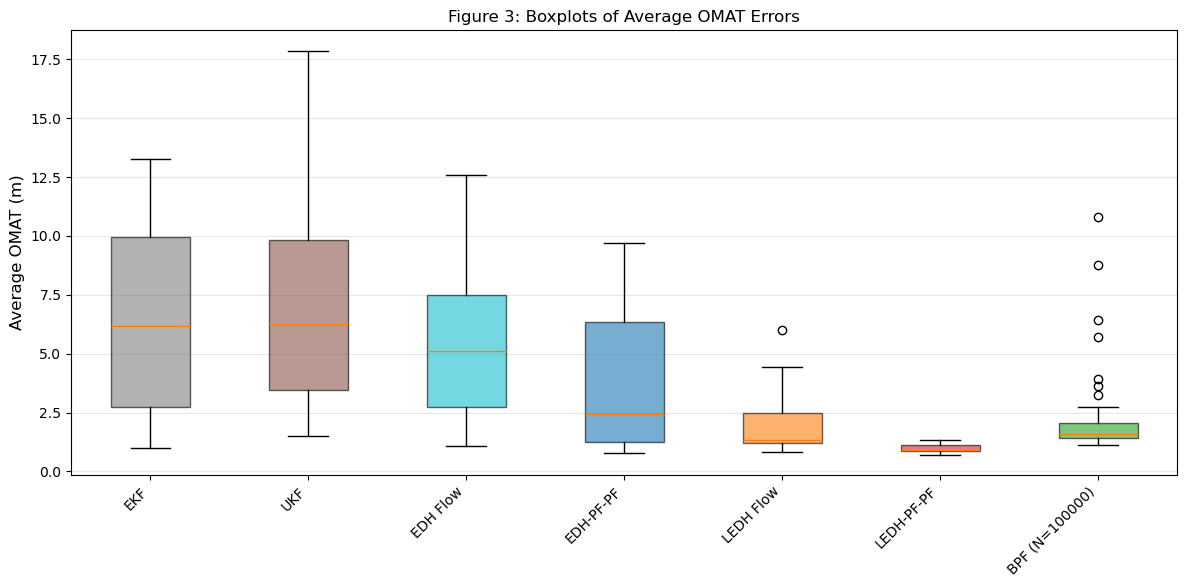

In [10]:
if results is not None:
    plot_figure3(results, filter_names, save_path='figure3_omat_boxplot.png')

---
## Figure 4: Average Effective Sample Size at Each Time Step

In [11]:
def plot_figure4(results, filter_names, save_path=None):
    """
    Plot Figure 4: Average ESS at each time step.
    
    Args:
        results: dict with filter results
        filter_names: list of filter names to plot
        save_path: Optional path to save figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Only plot filters with ESS (skip EKF, UKF)
    filters_with_ess = []
    
    for name in filter_names:
        ess_per_step = results[name].get('ess_per_step')
        if ess_per_step is None:
            continue
        
        # Check if all NaN
        if np.all(np.isnan(ess_per_step)):
            continue
        if np.all(ess_per_step == 500):
            continue
        filters_with_ess.append(name)
        
        # Average over trials
        mean_ess = np.nanmean(ess_per_step, axis=0)
        T = len(mean_ess)
        time_steps = np.arange(1, T + 1)
        
        # Get style
        color = FILTER_COLORS.get(name.split(' (')[0], 'black')
        linestyle = FILTER_LINESTYLES.get(name.split(' (')[0], '-')
        marker = FILTER_MARKERS.get(name.split(' (')[0], 'o')
        
        ax.plot(time_steps, mean_ess, 
                linestyle=linestyle, color=color,
                marker=marker, markevery=5,
                label=name)
    
    if not filters_with_ess:
        print("No filters with ESS data found.")
        return
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Average ESS')
    ax.set_title('Figure 4: Average Effective Sample Size at Each Time Step')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, T])
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

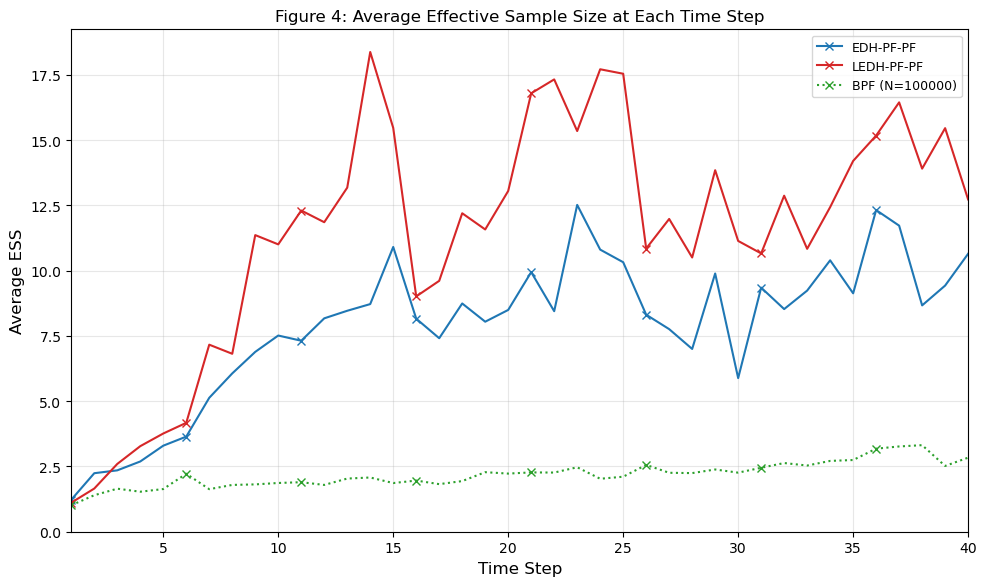

In [12]:
if results is not None:
    plot_figure4(results, filter_names, save_path='figure4_ess_vs_time.png')

---
## Table I: Summary Statistics

In [13]:
def create_table1(results, filter_names):
    """
    Create Table I: Summary statistics.
    
    Args:
        results: dict with filter results
        filter_names: list of filter names
        
    Returns:
        pandas DataFrame
    """
    rows = []
    
    for name in filter_names:
        omat_mean = results[name].get('omat_mean')
        ess_mean = results[name].get('ess_mean')
        runtime = results[name].get('runtime')
        
        # Calculate statistics
        if omat_mean is not None:
            valid_omat = omat_mean[~np.isnan(omat_mean)]
            omat_str = f"{np.mean(valid_omat):.2f} ± {np.std(valid_omat):.2f}" if len(valid_omat) > 0 else "N/A"
        else:
            omat_str = "N/A"
        
        if ess_mean is not None:
            valid_ess = ess_mean[~np.isnan(ess_mean)]
            ess_str = f"{np.mean(valid_ess):.1f} ± {np.std(valid_ess):.1f}" if len(valid_ess) > 0 else "N/A"
        else:
            ess_str = "N/A"
        
        if runtime is not None:
            valid_runtime = runtime[~np.isnan(runtime)]
            runtime_str = f"{np.mean(valid_runtime):.3f}" if len(valid_runtime) > 0 else "N/A"
        else:
            runtime_str = "N/A"
        
        rows.append({
            'Filter': name,
            'OMAT (m)': omat_str,
            'Avg ESS': ess_str,
            'Time (s)': runtime_str,
        })
    
    df = pd.DataFrame(rows)
    return df

In [14]:
if results is not None:
    table1 = create_table1(results, filter_names)
    print("Table I: Average OMAT Metrics, ESS and Execution Time per Step")
    print("=" * 70)
    display(table1)

Table I: Average OMAT Metrics, ESS and Execution Time per Step


,Filter,OMAT (m),Avg ESS,Time (s)
0,EKF,6.32 ± 3.68,N/A,0.003
1,UKF,7.00 ± 3.93,N/A,0.012
2,EDH Flow,5.25 ± 2.84,500.0 ± 0.0,0.127
3,EDH-PF-PF,3.74 ± 2.82,7.9 ± 1.9,0.192
4,LEDH Flow,1.92 ± 1.20,500.0 ± 0.0,45.343
5,LEDH-PF-PF,0.97 ± 0.14,11.4 ± 3.3,45.401
6,BPF (N=100000),2.27 ± 1.86,2.2 ± 0.5,11.446


In [ ]:
# Save table to CSV
if results is not None:
    table1.to_csv('table1_summary.csv', index=False)
    print("Table saved to table1_summary.csv")

---
## Run Experiment (if no saved results)

If you don't have saved results, run a quick experiment here.

In [ ]:
# Uncomment to run a quick experiment
"""
from experiments.acoustic_experiment import (
    run_experiment, print_summary, save_results_to_csv, save_results_to_npz
)

# Quick experiment (reduced settings for speed)
exp_results = run_experiment(
    T=40,
    n_tracks=5,           # Paper uses 100
    n_runs_per_track=2,   # Paper uses 5
    num_targets=4,
    n_particles=500,
    n_particles_bpf=10000,  # Paper uses 1e6
    use_redraw=True,
    verbose=True,
)

print_summary(exp_results)

# Save results
summary_path, trials_path = save_results_to_csv(exp_results, output_dir='results')
npz_path = save_results_to_npz(exp_results, output_dir='results')
print(f"Results saved to: {npz_path}")
"""